<a href="https://colab.research.google.com/github/emiliehp/DAT300/blob/emilie/CA5_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compulsory Assignment 5: Sentiment Analysis

Please fill out the the group name, number, members and optionally the name below.

 **Group number: 19**

 **Member 1: Anne Berit Alm**  
 **Member 2: Benjamin Andersen**  
 **Member 3: Emilie Hope Petersen**



## Assignment Submission
To complete this assignment answer the questions in this notebook and write the code required to implement the relevant models.
However, we reccomend that you start early. This assignment has subsections, each of which build upon the last. This assignment is completed by doing the following.

- Submit notebook as an .ipynb file to canvas.
- Submit notebook as an .pdf file to canvas.

Your submission must correctly implement the full pipeline to analyse the sentiment using a RNN and BERT models.


#### NOTE: It is recommended to use Google Colab with GPU enabled for CA5 tasks. Keras and TensorFlow (version ≥2) will automatically use the GPU if one is available

- Read tasks thoroughly before answering.
- Make sure to answer all tasks.
- Ensure all code cells are run.
- Ensure all figures are visible in the PDF.
- Provide a brief explanation of how your code works

# How to Use Google Colab for CA5

To work on the CA5 assignment in Google Colab, follow these steps:

---

### 1. Connect Google Colab to Google Drive
Your CA5 files should be stored in Google Drive so Colab can access them.  
Run the following code to mount your Drive:



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
project_path = "/content/drive/MyDrive/DAT300/CA5" #change this to your folder.
os.chdir(project_path)
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/DAT300/CA5


### Change Runtime to GPU

To use GPU in Google Colab:

1. Go to the top menu and click **Runtime** → **Change runtime type**.  
2. In the pop-up window, set **Hardware accelerator** to **GPU**.  
3. Click **Save**.  

Now your notebook will run on a GPU backend.

###**Note**: I recommend using the regular runtime first, as your GPU usage is limited. Write and test your code in the regular runtime to ensure everything works correctly before switching to the GPU for model training.

##Introduction
In this assignment, you will analyze whether a movie review is positive or negative. In Task 1, you will use a Recurrent Neural Network (RNN) to perform the analysis. In Task 2, you will be introduced to the encoder block of the Transformer architecture, commonly known as BERT. Finally, you will compare the results from both approaches and draw a conclusion.

**Note**: BERT stands for "Bidirectional Encoder Representations from Transformers"

###About the Dataset
The IMDb dataset is a collection of 50,000 reviews from the Internet Movie Database (IMDb). The reviews are labeled as either positive or negative.

The IMDb dataset is a binary sentiment analysis dataset for natural language processing or text analytics.

IMDb is a rich source of film data that includes cast and crew lists, movie release dates, box office information, plot summaries, trailers, actor and director biographies, and other trivia. Information on IMDb comes from a variety of sources, such as filmmakers, film studios, on-screen credits, and other official sources.

## Task 0: Load and Inspect the Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv("/content/drive/MyDrive/DAT300/CA5/IMDB Dataset.csv")

In [5]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


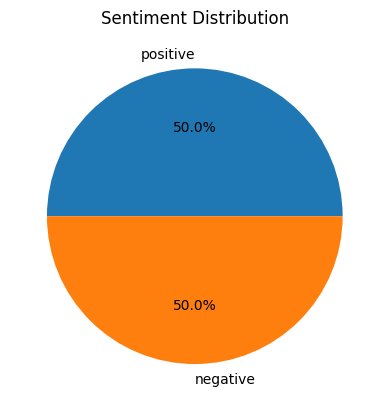

In [6]:
sentiment_counts = data["sentiment"].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title("Sentiment Distribution")
plt.show()


### Preprocess

In [7]:
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split

In [8]:
labels = data["sentiment"]
enc = LabelEncoder()
labels_encoded = enc.fit_transform(labels)
data["labels_encoded"] = labels_encoded

In [9]:
data.head()

,review,sentiment,labels_encoded
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [10]:
def clean_text(text):
    text = re.sub(r"<br\s*/?>", " ", text)  # remove <br> or <br />
    text = re.sub(r"&nbsp;", " ", text)
    text = re.sub(r"http\S+", " ", text)    # remove URLs
    text = re.sub(r"@\w+", " ", text)       # remove @mentions
    text = re.sub(r"[^A-Za-z0-9\s.,!?']", " ", text)# strip symbols
    text = re.sub(r"\s+", " ", text).strip()
    return text

data["review"] = data["review"].apply(clean_text)

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(data["review"], data["labels_encoded"], test_size=0.25)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## Task 1: RNN

### 1.1 Vectorize inputs

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, Sequential


max_tokens = 30000      # vocab size cap
max_len    = 128        # sequence length
vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=max_len,
    output_mode="int"
)


vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train).batch(1024))

X_train_vec = vectorizer(tf.constant(X_train.values))
X_test_vec  = vectorizer(tf.constant(X_test.values))
X_val_ved = vectorizer(tf.constant(X_val.values))

### Task 1.1 Create a simple RNN and an LSTM model

In [18]:
def simple_RNN_model():
    model = Sequential()
    model.add(layers.Embedding(max_tokens, 128, input_length=max_len))
    model.add(layers.SimpleRNN(128))
    model.add(layers.Dense(1, activation="sigmoid"))
    model.build(input_shape=(None, max_len))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()
    return model

def simple_LSTM_model():
    model = Sequential()
    model.add(layers.Embedding(max_tokens, 128, input_length=max_len))
    model.add(layers.LSTM(50, return_sequences=False))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.build(input_shape=(None, max_len))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()
    return model



### Compile and print out summary

### Task 1.2: Train your model




In [19]:
rnn_model = simple_RNN_model()
history_rnn = rnn_model.fit(
    X_train_vec,
    y_train,
    validation_data=(X_test_vec, y_test),
    epochs=5,
    batch_size=128
)

lstm_model = simple_LSTM_model()
history_lstm = lstm_model.fit(
    X_train_vec,
    y_train,
    validation_data=(X_test_vec, y_test),
    epochs=5,
    batch_size=128
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 128, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,873,025 (14.77 MB)

 Trainable params: 3,873,025 (14.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5030 - loss: 0.6988 - val_accuracy: 0.5126 - val_loss: 0.6937
Epoch 2/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5209 - loss: 0.6937 - val_accuracy: 0.5160 - val_loss: 0.6903
Epoch 3/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6081 - loss: 0.6605 - val_accuracy: 0.5312 - val_loss: 0.6906
Epoch 4/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6519 - loss: 0.6224 - val_accuracy: 0.5301 - val_loss: 0.6983
Epoch 5/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6340 - loss: 0.6322 - val_accuracy: 0.5766 - val_loss: 0.6886


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 128, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,875,851 (14.79 MB)

 Trainable params: 3,875,851 (14.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6508 - loss: 0.6134 - val_accuracy: 0.5814 - val_loss: 0.6622
Epoch 2/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6652 - loss: 0.6035 - val_accuracy: 0.8203 - val_loss: 0.4349
Epoch 3/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8785 - loss: 0.3236 - val_accuracy: 0.8362 - val_loss: 0.3987
Epoch 4/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9199 - loss: 0.2293 - val_accuracy: 0.8453 - val_loss: 0.3782
Epoch 5/5
293/293 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9533 - loss: 0.1509 - val_accuracy: 0.8501 - val_loss: 0.4181


### Task 1.3 Evaluate your models

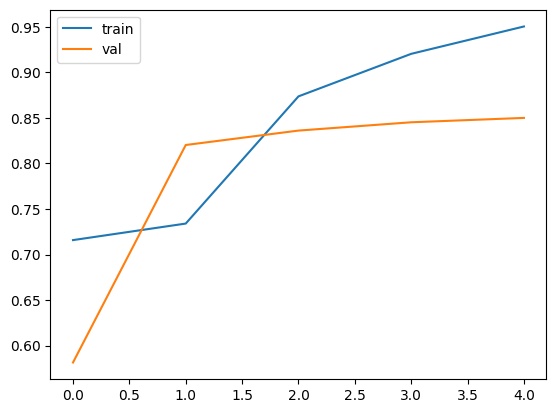

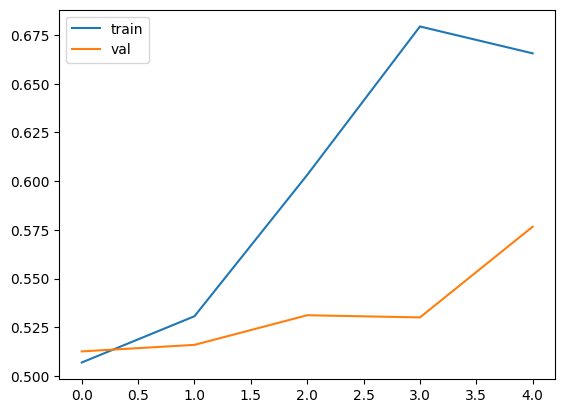

In [21]:
plt.plot(history_lstm.history["accuracy"])
plt.plot(history_lstm.history["val_accuracy"])
plt.legend(["train", "val"])
plt.show()

plt.plot(history_rnn.history["accuracy"])
plt.plot(history_rnn.history["val_accuracy"])
plt.legend(["train", "val"])
plt.show()


### Task 2: BERT

### Task 2.0: Install the trasformers package from HuggingFace

Hugging Face is an American company and an open-source community that provides tools, pre-trained machine learning models, and datasets, primarily focused on natural language processing (NLP) and other AI fields like computer vision and audio

**Note:** You may need to restart the runtime after installing the packages. Then, mount your Google Drive and rerun Task 0.

In [ ]:
!pip install -U "tensorflow>=2.17,<2.21" "keras>=3.3.0" "tf-keras>=2.17" "transformers>=4.44.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 134.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.19.0
    Uninstalling tf_keras-2.19.0:
      Successfully uninstalled tf_keras-2.19.0
ERROR: pip's dependency reso

In [ ]:
import tf_keras as keras
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, AutoTokenizer

### Task 2.1: Load the destilbert model

In this part of the assignment, we will use a smaller and faster version of BERT called DistilBERT. It is significantly more lightweight and trains much faster than the original BERT model. Here is the illustration of its architecture:

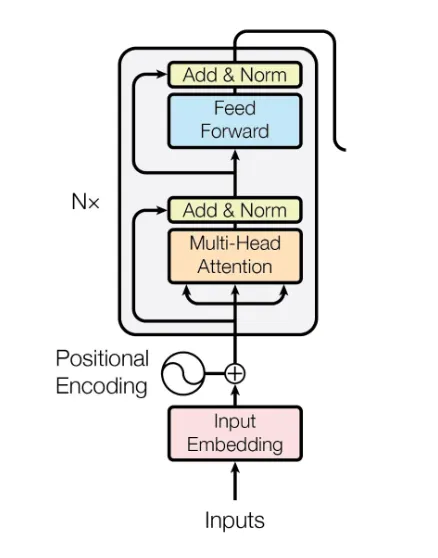

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model =  TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2, from_pt=True)

### Task 2.2: Split the training data to Validation and training

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

### Task 2.3: Tokenize

You have to tokenize your inputs again, use the AutoTokenizer that we imported earlier.

In [ ]:
max_len   = 128
batch_sz  = 64
epochs    = 3

enc_train = tokenizer(
    X_train.astype(str).tolist(), truncation=True, padding="max_length",
    max_length=max_len, return_tensors="np"
)
enc_val = tokenizer(
    X_val.astype(str).tolist(), truncation=True, padding="max_length",
    max_length=max_len, return_tensors="np"
)


### Create datasets

This step wraps your input features (enc_train, e.g., input_ids and attention_mask) and labels (y_train) into a TensorFlow-native streaming dataset.

The TensorFlow Dataset API provides an efficient way to feed data to your model:

* Streams data efficiently from RAM or disk.

* Performs batching, shuffling, and preprocessing in parallel on the CPU.

* Keeps the GPU busy by prefetching the next batch while training.

* Integrates seamlessly with Hugging Face's encoded token dictionaries.




In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((dict(enc_train), y_train))
ds_train = ds_train.map(lambda x, y: (x, tf.cast(tf.squeeze(y), tf.int32))) \
                   .shuffle(10000).batch(batch_sz).prefetch(tf.data.AUTOTUNE)

ds_val = tf.data.Dataset.from_tensor_slices((dict(enc_val), y_val))
ds_val = ds_val.map(lambda x, y: (x, tf.cast(tf.squeeze(y), tf.int32))) \
               .batch(batch_sz).prefetch(tf.data.AUTOTUNE)


### Task 2.4: Create and Compile model

### Task 2.5: Train your model

### Task 2.6: Evaluate


## Task 3: Compare

3.1: Compare the results of the two models. What could explain the differences in their performance?

**Answer:**

3.2: Why did we need to tokenize the inputs again using a different tokenizer in Task 2.3?

**Answer:**

3.3: Briefly explain the main difference between RNNs and Transformer architectures.

**Answer:**


## Task 4: Reading Exercise (Optional)

If you truly want to understand the logic behind ChatGPT and the motivation for Transformers, I encourage you to read the 2017 paper “[Attention Is All You Need.](https://arxiv.org/pdf/1706.03762)” In this paper, engineers from Google explain in detail how the architecture was built and why it represents such a major breakthrough.